In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn

import matplotlib.pyplot as plt
% matplotlib inline

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import warnings; warnings.simplefilter('ignore')
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance

from sklearn import cross_validation

from sklearn import metrics
# Any results you write to the current directory are saved as output.

In [2]:
train_data = pd.read_csv('train.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [3]:
# Number of outcome classes
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [4]:
test_data = pd.read_csv('test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [5]:
data = pd.concat([train_data, test_data]).reset_index(drop=True)
data_rd1 = data.copy()
data_rd1.drop(labels='Cabin', axis=1, inplace=True)
data_rd1.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [6]:
# Create function for extracting information from Name
import re
import string
def name_parsing(text):
    # Remove bracket content
    title = []
    middle_name = []
    last_name = []
    
    title_bank = ['Miss', 'Mr', 'Mrs', 'Dr', 'Master', 'Major', 'Rev', 'Capt', 'Lady',
       'Mme', 'Ms', 'Col', 'Mlle']
    
    for i in range(len(text)):
        # Remove the content in bracket
        text.iloc[i] = re.sub("[\(\[].*?[\)\]]", "",text.iloc[i])
        # Remove punctuation
        translation = text.iloc[i].maketrans("","", string.punctuation)
        # Split
        # ext_trans = text[i].translate(translation)
        text_split = text.iloc[i].split()
        lastname_flag = 0
        title_flag = 0
        for j in range(len(text_split)):
            if (',' in text_split[j]) & (lastname_flag == 0):
                last_name.append(text_split[j].translate(translation))
                last_name_flag = 1
            
            if ('.' in text_split[j]) & (title_flag == 0):
                title.append(text_split[j].translate(translation))                
                title_flag = 1                
    
        if last_name_flag == 0:
            last_name.append(np.nan)
        
        if title_flag == 0:
            title.append(np.nan)
            
        # first_name.append(text_split[-2].translate(translation))
        middle_name.append(text_split[-1].translate(translation))
        
    return pd.Series(title), pd.Series(last_name), pd.Series(middle_name)

In [7]:
title, last, middle = name_parsing(data_rd1['Name'])

In [8]:
name_type = title.unique()
name_map = {}

for i in range(len(name_type)):
    name_map[name_type[i]] = i

title_name_num = title.map(name_map)
data_rd1['title_name'] = list(title)

In [9]:
data_male = data_rd1[data_rd1['Sex']=='male']
data_male['title_name'].unique()

title_male_type = data_male['title_name'].unique()

for i in range(len(title_male_type)):
    male_master_median = data_male[data_male['title_name']==title_male_type[i]]['Age'].median()
    data_rd1.loc[(data_rd1['Sex']=='male')&(data_rd1['title_name']==title_male_type[i]), 'Age'] = data_rd1.loc[(data_rd1['Sex']=='male')&(data_rd1['title_name']==title_male_type[i]), 'Age'].fillna(male_master_median)

In [10]:
female_age_median = data_rd1[data_rd1['Sex']=='female']['Age'].median()
data_rd1.loc[data_rd1['Sex']=='female', 'Age'] = data_rd1.loc[data_rd1['Sex']=='female', 'Age'].fillna(female_age_median)

In [11]:
# To many categorical values for titles, try combining them and apply one hot
data_rd1['title_name'].value_counts()/np.sum(data_rd1['title_name'].value_counts())*100

Mr          57.830405
Miss        19.862490
Mrs         15.049656
Master       4.660046
Rev          0.611154
Dr           0.611154
Col          0.305577
Mlle         0.152788
Major        0.152788
Ms           0.152788
Sir          0.076394
Countess     0.076394
Mme          0.076394
Don          0.076394
Dona         0.076394
Jonkheer     0.076394
Lady         0.076394
Capt         0.076394
Name: title_name, dtype: float64

In [12]:
# Combine the features that have small than 5%
keep_title = ['Mr', 'Miss', 'Mrs', 'Master']

data_rd1.ix[~data_rd1['title_name'].isin(keep_title), 'title_name'] = np.nan

In [13]:
data_rd1['title_name'].value_counts()/np.sum(data_rd1['title_name'].value_counts())*100

Mr        59.372549
Miss      20.392157
Mrs       15.450980
Master     4.784314
Name: title_name, dtype: float64

In [14]:
# Use one hot encoding to encode the titie and drop one column 
one_hot_title =pd.get_dummies(data_rd1['title_name'])

In [15]:
data_rd1=data_rd1.join(one_hot_title, how='outer')

In [16]:
data_rd1.drop('title_name', axis=1, inplace=True)

In [17]:
data_rd1.drop('Name', axis=1, inplace=True)

In [18]:
# Use mapping function to convert Sex into binary digits
data_rd1['Sex'] = data_rd1['Sex'].map({'female':1, 'male':0})

In [19]:
# Extract number information from ticket
ticket_ori = data_rd1['Ticket']

ticket_num = []
for tk in range(len(ticket_ori)):
    if len(re.findall(r'\d+', ticket_ori.iloc[tk])) ==0 :
        ticket_num.append(np.nan)
    else:
        ticket_num.append(np.int(re.findall(r'\d+', ticket_ori.iloc[tk])[-1]))
        
data_rd1['ticket_num'] = ticket_num

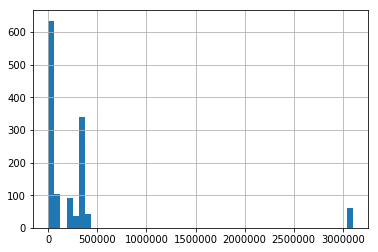

In [20]:
# The abolute number of ticket is not critical, bin in and convert to one hot
data_rd1['ticket_num'].hist(bins=50)

In [21]:
# Set ticket number into 3 bins: < 100000, 10000~500000, > 500000
data_rd1.ix[data_rd1['ticket_num']<100000,'ticket_num'] = 0
data_rd1.ix[data_rd1['ticket_num']>500000,'ticket_num'] = 2
data_rd1.ix[(data_rd1['ticket_num']>100000)&(data_rd1['ticket_num']<500000),'ticket_num'] = 1

In [22]:
ticket_num_onehot = pd.get_dummies(data_rd1['ticket_num'])
ticket_num_onehot = ticket_num_onehot.add_prefix('ticketnum')
data_rd1 = data_rd1.join(ticket_num_onehot, how='outer')

In [23]:
# Use mapping function to convert Sex into binary digits
data_rd1['Group_size']= data_rd1['SibSp'] + data_rd1['Parch']
data_rd1.drop('SibSp', axis=1, inplace=True)
data_rd1.drop('Parch', axis=1, inplace=True)

In [24]:
# data_rd1['Norm_fare'] = np.divide(data_rd1['Fare'],[np.max([data_rd1.iloc[i]['Group_size'],1]) for i in range(len(data_rd1))])
# data_rd1.drop('Group_size', axis=1, inplace=True)
# data_rd1.drop('Fare', axis=1, inplace=True)

In [25]:
one_hot_embarked = pd.get_dummies(data_rd1['Embarked'])
one_hot_embarked = one_hot_embarked.add_prefix('Embarked_')

In [26]:
data_rd1 = data_rd1.join(one_hot_embarked, how='outer')
data_rd1.drop('Embarked', axis=1, inplace=True)

In [27]:
data_rd1.drop('Ticket', axis=1, inplace=True)

In [28]:
data_rd1.drop('ticket_num', axis=1, inplace=True)

In [29]:
drop_list = ['Embarked_S','Embarked_C','Embarked_Q']
for i in range(len(drop_list)):
    data_rd1.drop(drop_list[i], axis=1, inplace=True)

In [30]:
data_rd1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 14 columns):
Age             1309 non-null float64
Fare            1308 non-null float64
PassengerId     1309 non-null int64
Pclass          1309 non-null int64
Sex             1309 non-null int64
Survived        891 non-null float64
Master          1309 non-null uint8
Miss            1309 non-null uint8
Mr              1309 non-null uint8
Mrs             1309 non-null uint8
ticketnum0.0    1309 non-null uint8
ticketnum1.0    1309 non-null uint8
ticketnum2.0    1309 non-null uint8
Group_size      1309 non-null int64
dtypes: float64(3), int64(4), uint8(7)
memory usage: 90.8 KB


In [31]:
# Split into train and validation set
#train_data1_part1 = data_rd1[(data_rd1['PassengerId']<892)&(data_rd1['Age']<15)].sample(frac=0.5, random_state=1).reset_index(drop=True)   # Shuffle the data
#train_data1_part2 = data_rd1[(data_rd1['PassengerId']<892)&(data_rd1['Age']>15)].sample(frac=1, random_state=1).reset_index(drop=True)   # Shuffle the data
#train_data1 = pd.concat([train_data1_part1, train_data1_part2])
from sklearn.model_selection import train_test_split

train_data = data_rd1[data_rd1['PassengerId']<892]
X_train, X_vali,y_train,y_vali = train_test_split(train_data, train_data['Survived'], test_size=0.1, random_state=23, stratify=train_data['Survived'])

In [32]:
print(sorted(Counter(y_train).items()))

[(0.0, 494), (1.0, 307)]


In [33]:
from imblearn.combine import SMOTETomek

smote = SMOTE(random_state=0, ratio=1)
X_resampled, y_resampled = smote.fit_sample(X_train, y_train)

In [34]:
print(sorted(Counter(y_resampled).items()))

[(0.0, 494), (1.0, 494)]


In [35]:
train_data1 = pd.DataFrame(X_resampled, columns=data_rd1.columns)
vali_data1 = pd.DataFrame(X_vali, columns=data_rd1.columns)
train_data1.drop('PassengerId', axis=1, inplace=True)
vali_data1.drop('PassengerId', axis=1, inplace=True)
train_target1 = train_data1['Survived']
vali_target1 = vali_data1['Survived']
train_data1.drop('Survived', axis=1, inplace=True)
vali_data1.drop('Survived', axis=1, inplace=True)

In [36]:
# train_target1 = 1-train_target1
# vali_target1 = 1-vali_target1

### Perform hyperparameter search on XGB classifier 

In [37]:
# XGB_clf = XGBClassifier()
# XGB_clf.fit(train_data1, train_target1)

# plot_importance(XGB_clf)
# plt.show()


# XGB_predict = XGB_clf.predict(train_data1)
# print('XGB classifier training accuracy:{}'.format(f1_score(XGB_predict, train_target1)))

In [38]:
def modelfit(alg, dtrain, targets, performCV=True, printFeatureImportance=True, cv_folds=10):
    
    #Fit the algorithm on the data
    alg.fit(dtrain, targets)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain, targets, cv=cv_folds, scoring='accuracy')
    
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(targets.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(targets, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        plot_importance(alg)
        plt.show()

In [67]:
param_test1 = {
 'n_estimators':range(10,60,10),
 'max_depth':range(1,5,2),
 'min_child_weight':range(1,5,2)
}

estimator1 = XGBClassifier( learning_rate =0.1, n_estimators=90, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1', iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.81352, std: 0.08260, params: {'min_child_weight': 1, 'n_estimators': 10, 'max_depth': 1},
  mean: 0.82153, std: 0.08082, params: {'min_child_weight': 1, 'n_estimators': 20, 'max_depth': 1},
  mean: 0.82354, std: 0.07806, params: {'min_child_weight': 1, 'n_estimators': 30, 'max_depth': 1},
  mean: 0.83161, std: 0.08164, params: {'min_child_weight': 1, 'n_estimators': 40, 'max_depth': 1},
  mean: 0.83710, std: 0.08214, params: {'min_child_weight': 1, 'n_estimators': 50, 'max_depth': 1},
  mean: 0.81352, std: 0.08260, params: {'min_child_weight': 3, 'n_estimators': 10, 'max_depth': 1},
  mean: 0.82153, std: 0.08082, params: {'min_child_weight': 3, 'n_estimators': 20, 'max_depth': 1},
  mean: 0.82354, std: 0.07806, params: {'min_child_weight': 3, 'n_estimators': 30, 'max_depth': 1},
  mean: 0.83161, std: 0.08164, params: {'min_child_weight': 3, 'n_estimators': 40, 'max_depth': 1},
  mean: 0.83710, std: 0.08214, params: {'min_child_weight': 3, 'n_estimators': 50, 'max_depth': 1},


In [69]:
param_test1 = {
 'n_estimators':range(20,35,1),
 'max_depth':range(2,4,1),
 #'min_child_weight':range(4,6,1)
}
estimator1 = XGBClassifier( learning_rate =0.1, n_estimators=90, max_depth=7,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1', iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83938, std: 0.07711, params: {'n_estimators': 20, 'max_depth': 2},
  mean: 0.83938, std: 0.07711, params: {'n_estimators': 21, 'max_depth': 2},
  mean: 0.84110, std: 0.07610, params: {'n_estimators': 22, 'max_depth': 2},
  mean: 0.84019, std: 0.07622, params: {'n_estimators': 23, 'max_depth': 2},
  mean: 0.84194, std: 0.07526, params: {'n_estimators': 24, 'max_depth': 2},
  mean: 0.84110, std: 0.07610, params: {'n_estimators': 25, 'max_depth': 2},
  mean: 0.84096, std: 0.07724, params: {'n_estimators': 26, 'max_depth': 2},
  mean: 0.84096, std: 0.07724, params: {'n_estimators': 27, 'max_depth': 2},
  mean: 0.84096, std: 0.07724, params: {'n_estimators': 28, 'max_depth': 2},
  mean: 0.84096, std: 0.07724, params: {'n_estimators': 29, 'max_depth': 2},
  mean: 0.84229, std: 0.07595, params: {'n_estimators': 30, 'max_depth': 2},
  mean: 0.84313, std: 0.07509, params: {'n_estimators': 31, 'max_depth': 2},
  mean: 0.84313, std: 0.07509, params: {'n_estimators': 32, 'max_depth': 2},

In [70]:
param_test1 = {
  'gamma':[i/10.0 for i in range(0,5)]
}
estimator1 = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1', iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.85589, std: 0.07104, params: {'gamma': 0.0},
  mean: 0.85589, std: 0.07104, params: {'gamma': 0.1},
  mean: 0.85589, std: 0.07104, params: {'gamma': 0.2},
  mean: 0.85589, std: 0.07104, params: {'gamma': 0.3},
  mean: 0.85482, std: 0.07012, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.85588547099222789)

In [71]:
param_test1 = {
 'subsample':[i/10.0 for i in range(2,10)],
 'colsample_bytree':[i/10.0 for i in range(4,10)]
}
estimator1 = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1', iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83923, std: 0.06362, params: {'subsample': 0.2, 'colsample_bytree': 0.4},
  mean: 0.84967, std: 0.06639, params: {'subsample': 0.3, 'colsample_bytree': 0.4},
  mean: 0.85129, std: 0.06604, params: {'subsample': 0.4, 'colsample_bytree': 0.4},
  mean: 0.85181, std: 0.06809, params: {'subsample': 0.5, 'colsample_bytree': 0.4},
  mean: 0.85104, std: 0.06806, params: {'subsample': 0.6, 'colsample_bytree': 0.4},
  mean: 0.85048, std: 0.06623, params: {'subsample': 0.7, 'colsample_bytree': 0.4},
  mean: 0.84986, std: 0.06799, params: {'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: 0.85338, std: 0.06771, params: {'subsample': 0.9, 'colsample_bytree': 0.4},
  mean: 0.83776, std: 0.07510, params: {'subsample': 0.2, 'colsample_bytree': 0.5},
  mean: 0.84294, std: 0.07308, params: {'subsample': 0.3, 'colsample_bytree': 0.5},
  mean: 0.84397, std: 0.07405, params: {'subsample': 0.4, 'colsample_bytree': 0.5},
  mean: 0.84750, std: 0.07219, params: {'subsample': 0.5, 'colsample_bytree'

In [76]:
param_test1 = {
  'subsample':[i/100.0 for i in range(60,90,5)],
 'colsample_bytree':[i/100.0 for i in range(60,90,5)]
}
estimator1 = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1', iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.85194, std: 0.06661, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.84902, std: 0.06784, params: {'subsample': 0.65, 'colsample_bytree': 0.6},
  mean: 0.85410, std: 0.06917, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.85602, std: 0.06716, params: {'subsample': 0.75, 'colsample_bytree': 0.6},
  mean: 0.85489, std: 0.07016, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.85523, std: 0.06995, params: {'subsample': 0.85, 'colsample_bytree': 0.6},
  mean: 0.85194, std: 0.06661, params: {'subsample': 0.6, 'colsample_bytree': 0.65},
  mean: 0.84902, std: 0.06784, params: {'subsample': 0.65, 'colsample_bytree': 0.65},
  mean: 0.85410, std: 0.06917, params: {'subsample': 0.7, 'colsample_bytree': 0.65},
  mean: 0.85602, std: 0.06716, params: {'subsample': 0.75, 'colsample_bytree': 0.65},
  mean: 0.85489, std: 0.07016, params: {'subsample': 0.8, 'colsample_bytree': 0.65},
  mean: 0.85523, std: 0.06995, params: {'subsample': 0.85, 'colsam

In [78]:
param_test1 = {
   'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
estimator1 = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.75, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator1, param_grid = param_test1, scoring='f1', iid=False, cv=10)
gsearch1.fit(train_data1, train_target1)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.85636, std: 0.06559, params: {'reg_alpha': 0},
  mean: 0.85636, std: 0.06559, params: {'reg_alpha': 1e-05},
  mean: 0.85636, std: 0.06559, params: {'reg_alpha': 0.01},
  mean: 0.85395, std: 0.06590, params: {'reg_alpha': 0.1},
  mean: 0.84884, std: 0.07255, params: {'reg_alpha': 1},
  mean: 0.82894, std: 0.07418, params: {'reg_alpha': 100}],
 {'reg_alpha': 0},
 0.8563579037212149)

In [310]:
# Sampling method: SMOTE, Metric: Accuracy
xgb_clf1 = XGBClassifier(learning_rate =0.1, n_estimators=87, max_depth=7,
 min_child_weight=3, gamma=0, subsample=0.4, colsample_bytree=0.7,reg_alpha = 0.1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [46]:
# Sampling method: SMOTE, Metric: Recall

xgb_clf2= XGBClassifier( learning_rate =0.1, n_estimators=122, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha = 0,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [47]:
# Combined Sampling + accuracy
xgb_clf3= XGBClassifier( learning_rate =0.1, n_estimators=124, max_depth=9,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [113]:
# STOME Sampling + Precision
xgb_clf4 = XGBClassifier( learning_rate =0.01, n_estimators=143, max_depth=3,
 min_child_weight=5, gamma=0, subsample=0.6, colsample_bytree=0.75,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [49]:
# Combine Sampling, ratio = 0.8 + accuracy
xgb_clf5 = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.75, colsample_bytree=0.8,reg_alpha = 0.1,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [50]:
# STOME Sampling, inverse lable, recall
xgb_clf6 = XGBClassifier( learning_rate =0.1, n_estimators=130, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.3, colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [118]:
# STOME Sampling, inverse lable, recall
xgb_clf7 = XGBClassifier(learning_rate =0.1, n_estimators=120, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

In [79]:
# STOME Sampling, non-inverse lable, f1
xgb_clf8 = XGBClassifier(learning_rate =0.1, n_estimators=25, max_depth=3,
 min_child_weight=1, gamma=0, subsample=0.75, colsample_bytree=0.7,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27)


Model Report
Accuracy : 0.9018
AUC Score (Train): 0.957010
CV Score : Mean - 0.8567347 | Std - 0.06993786 | Min - 0.76 | Max - 0.9591837


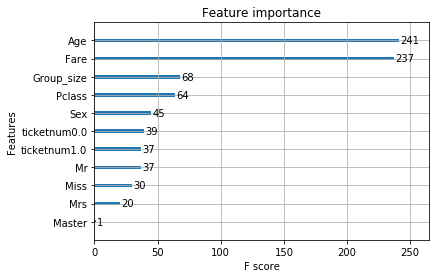

In [85]:
modelfit(xgb_clf1, train_data1, train_target1)

In [311]:
from sklearn.metrics import confusion_matrix
xgb_clf1.fit(train_data1, train_target1)
xgb_predict = xgb_clf1.predict(train_data1)
accuracy_score(train_target1, xgb_predict)
# confusion_matrix(train_target1, xgb_predict)

0.90182186234817818

In [159]:
xgb_predict_vali = xgb_clf1.predict(vali_data1)
accuracy_score(vali_target1, xgb_predict_vali)
confusion_matrix(vali_target1, xgb_predict_vali)

array([[54,  1],
       [10, 25]])

In [124]:
train_data_final = data_rd1[data_rd1['PassengerId']<892]
train_target_final = train_data_final['Survived']
train_data_final.drop('Survived', axis=1, inplace=True)
train_data_final.drop('PassengerId', axis=1, inplace=True)

In [312]:
test_data = data_rd1[data_rd1['PassengerId']>891]
test_data.drop('PassengerId', axis=1, inplace=True)
test_data.drop('Survived', axis=1 ,inplace=True)

In [313]:
test_predict = xgb_clf1.predict(test_data)

In [301]:
train_data_sub = pd.concat([train_data_final['Age'], train_data_final['Fare'],  train_data_final['Group_size'],  train_data_final['Sex'], train_data_final['Pclass']], axis=1)
test_data_sub = pd.concat([test_data['Age'], test_data['Fare'],  test_data['Group_size'],  test_data['Sex'],test_data['Pclass']], axis=1) 

In [209]:
train_data_sub.head()

,Age,Fare,Group_size,Sex,Pclass
0,22.0,7.2500,1,0,3
1,38.0,71.2833,1,1,1
2,26.0,7.9250,0,1,3
3,35.0,53.1000,1,1,1
4,35.0,8.0500,0,0,3


In [306]:
test_data_fare_mean = test_data['Fare'].mean()
test_data_sub['Fare'] = test_data_sub['Fare'].fillna(test_data_fare_mean)

In [308]:
test_data_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 5 columns):
Age           418 non-null float64
Fare          418 non-null float64
Group_size    418 non-null int64
Sex           418 non-null int64
Pclass        418 non-null int64
dtypes: float64(2), int64(3)
memory usage: 19.6 KB


In [298]:
# Combine with multilayer perceptron

from sklearn.neural_network import MLPClassifier
MLP_clf = MLPClassifier(hidden_layer_sizes=(50, 10), random_state=0, activation='tanh', alpha=0.0005)
MLP_clf.fit(train_data_sub, train_target_final)

MLPClassifier(activation='tanh', alpha=0.0005, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [299]:
MLP_predict = MLP_clf.predict(train_data_sub)
accuracy_score(MLP_predict, train_target_final)

0.8125701459034792

In [309]:
MLP_predict_test = MLP_clf.predict(test_data_sub)

In [332]:
final_predict = np.concatenate((MLP_predict_test.reshape(-1,1), test_predict.reshape(-1,1)), axis=1)

In [333]:
final_predict.shape

(418, 2)

In [336]:
list(np.max(final_predict, axis=1))

[0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0

In [316]:
MLP_predict_test

array([ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,
        0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0